# A Simple RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

import warnings
warnings.filterwarnings('ignore')

/home/ss/anaconda3/envs/pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.8.2


In [2]:
# It is a simple function to plot time x axis values y axis

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Inputs: data series, size of the window,The size of the batches to use when training,
# the size of the shuffle buffer, which determines how the data will be shuffled.
#
# Expand the dimensions of the series to work with the LSTM's
# Create dataset ds from the series
# Slice the data up into the appropriate windows, shifted by one time set.
# keep them all the same size by setting drop remainder to true.
# flatten the data into chunks in the size of our window_size + 1.
# Shuffle it with shuffle buffer that speeds things up with large datasets
# Return the dataset that batched into the selected batch size 

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
# We can use this function to make some prediction by using the trained model 

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
df_sun = pd.read_csv('./data/train.csv')
print(df_sun.shape)
df_sun.head()

(29701, 8)


,t,1,2,3,4,time,x,y
0,0.00,119.947865,102.751992,100.623908,101,0.00,15.860380,-23.297520
1,0.01,119.927054,102.738962,100.628316,101,0.01,15.860189,-23.298586
2,0.02,119.906244,102.725932,100.632724,101,0.02,15.859999,-23.299651
3,0.03,119.885434,102.712902,100.637131,101,0.03,15.859808,-23.300717
4,0.04,119.864623,102.699872,100.641539,101,0.04,15.859618,-23.301783


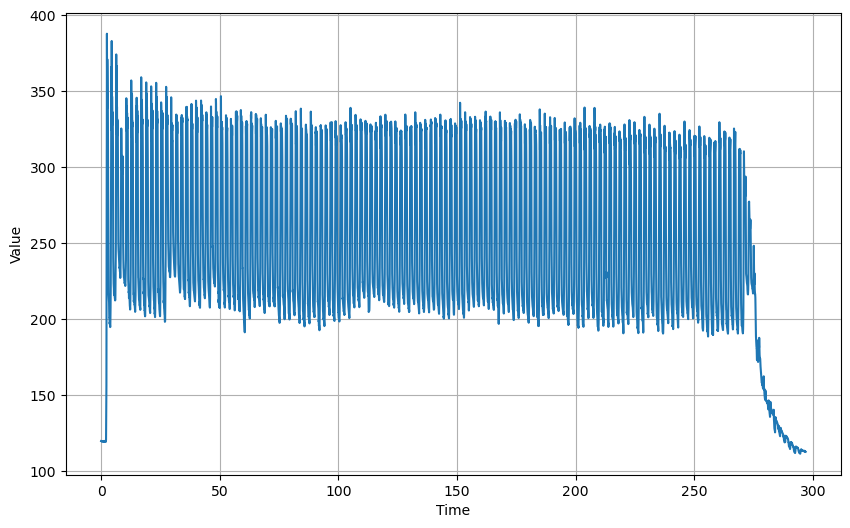

In [6]:
# Let's visualize the data
time = df_sun['t']
series = df_sun['1']
series_2 = df_sun['2']
series_3 = df_sun['3']
series_4 = df_sun['4']
series_x = df_sun['x']
series_y = df_sun['y']

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
# Let's take 80% of the data as train set
split_time = 20000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

print(x_train.shape)
print(x_valid.shape)

(20000,)
(9701,)


In [8]:
# Let's define random_seeds and the variables
# Clear keras session 
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 128

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(20000,)


2022-11-02 16:21:51.388335: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 16:21:51.388719: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
# We use "lr_schedule" to see which "learning rate" is optimum 
# Run the model with less epoch to visualize "learning rate" vs "loss"
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                    lambda epoch: 1e-8 * 10**(epoch/20))
# Optimizer and loos parameters
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
loss = tf.keras.losses.Huber()

In [10]:
# Build and Fit the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
156/156 [==============================] - 42s 255ms/step - loss: 180.1630 - mse: 40333.2344 - lr: 1.0000e-08
Epoch 2/100
156/156 [==============================] - 40s 256ms/step - loss: 64.0596 - mse: 8099.9019 - lr: 1.1220e-08
Epoch 3/100
156/156 [==============================] - 40s 254ms/step - loss: 57.7214 - mse: 6494.5293 - lr: 1.2589e-08
Epoch 4/100
156/156 [==============================] - 39s 253ms/step - loss: 56.0735 - mse: 6027.0483 - lr: 1.4125e-08
Epoch 5/100
 46/156 [=======>......................] - ETA: 30s - loss: 56.3638 - mse: 6258.0308

KeyboardInterrupt: 

In [13]:
# Let's visualize "learning rate" vs "loss"
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 80])

NameError: name 'history' is not defined

In [36]:
# Let's rerun the model with the optimul learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.SGD(lr=2e-7, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=200)

Epoch 1/200
312/312 [==============================] - 54s 167ms/step - loss: 86.1607 - mae: 86.6582
Epoch 2/200
312/312 [==============================] - 51s 164ms/step - loss: 39.1645 - mae: 39.6604
Epoch 3/200
312/312 [==============================] - 52s 165ms/step - loss: 32.1276 - mae: 32.6230
Epoch 4/200
312/312 [==============================] - 53s 168ms/step - loss: 27.5805 - mae: 28.0730
Epoch 5/200
312/312 [==============================] - 51s 162ms/step - loss: 24.8957 - mae: 25.3874
Epoch 6/200
312/312 [==============================] - 52s 167ms/step - loss: 22.6098 - mae: 23.1009
Epoch 7/200
312/312 [==============================] - 52s 168ms/step - loss: 20.7381 - mae: 21.2289
Epoch 8/200
312/312 [==============================] - 51s 164ms/step - loss: 19.1164 - mae: 19.6071
Epoch 9/200
312/312 [==============================] - 51s 163ms/step - loss: 17.5293 - mae: 18.0209
Epoch 10/200
312/312 [==============================] - 51s 164ms/step - loss: 16.5548 - ma

First 10 Predictions : 
 [322.50046 322.94064 323.46573 323.61993 323.56558 323.43427 323.2868
 323.2187  323.12488 322.96353]

mae :  2.4521875


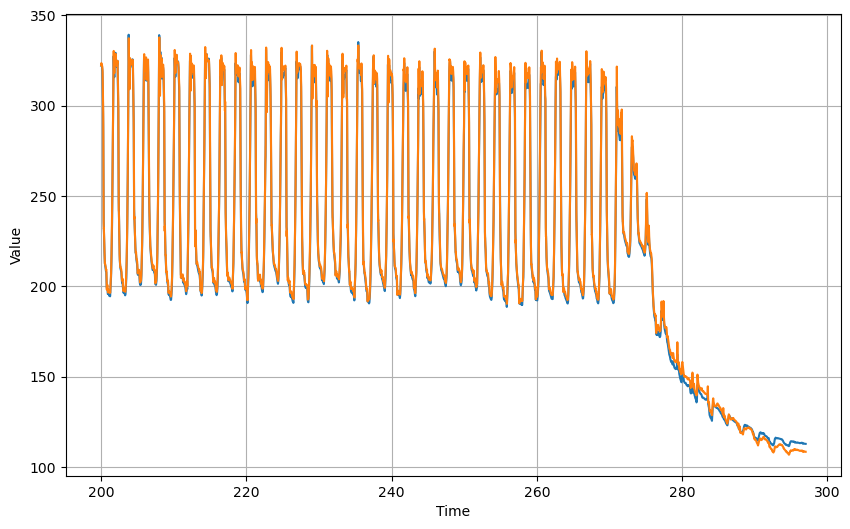

In [37]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print("First 10 Predictions :","\n", rnn_forecast[:10])
print('')
print("mae : ", tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)